# Unconditional investigation

**Table of contents**<a id='toc0_'></a>    
- 1. [Imports](#toc1_)    
- 2. [Load data](#toc2_)    
- 3. [Calculations](#toc3_)    
- 4. [Time series](#toc4_)    
  - 4.1. [raw vs. filted](#toc4_1_)    
  - 4.2. [transition rates](#toc4_2_)    
  - 4.3. [Filtering method](#toc4_3_)    
  - 4.4. [Approximation](#toc4_4_)    
  - 4.5. [Decomposition](#toc4_5_)    
  - 4.6. [Dynamic correlation](#toc4_6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Imports](#toc0_)

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

## 2. <a id='toc2_'></a>[Load data](#toc0_)

In [2]:
with open('data/data.p', 'rb') as f:
    data = pickle.load(f)

## 3. <a id='toc3_'></a>[Calculations](#toc0_)

In [3]:
I = data['EU'].notna() & data['UE'].notna() & data['u'].notna()

cycle_EU,_ = sm.tsa.filters.cffilter(np.log(data['EU'][I]),12,np.inf,drift=False)
cycle_UE,_ = sm.tsa.filters.cffilter(np.log(data['UE'][I]),12,np.inf,drift=False)
cycle_u,_ = sm.tsa.filters.cffilter(np.log(data['u'][I]),12,np.inf,drift=False)

cycle_u_hp, trend = sm.tsa.filters.hpfilter(np.log(data['u'][I]),lamb=1600*3**4)
cycle_u_hp_shimer, trend = sm.tsa.filters.hpfilter(np.log(data['u'][I]),lamb=10**5*3**4)

ss_EU = np.mean(data['EU'][I])
ss_UE = np.mean(data['UE'][I])
ss_u = np.mean(data['u'][I])

EU = ss_EU + (cycle_EU-np.mean(cycle_EU))*ss_EU
UE = ss_UE + (cycle_UE-np.mean(cycle_UE))*ss_UE
u = ss_u + (cycle_u-np.mean(cycle_u))*ss_u
u_hp = ss_u + cycle_u_hp*ss_u
u_hp_shimer = ss_u + cycle_u_hp_shimer*ss_u

## 4. <a id='toc4_'></a>[Time series](#toc0_)

In [4]:
USREC = data.USREC[I]
start_vec = data[I].index[(USREC == 1) & (USREC.shift(1) == 0)]
end_vec = data[I].index[(USREC == 1) & (USREC.shift(-1) == 0)]

### 4.1. <a id='toc4_1_'></a>[raw vs. filted](#toc0_)

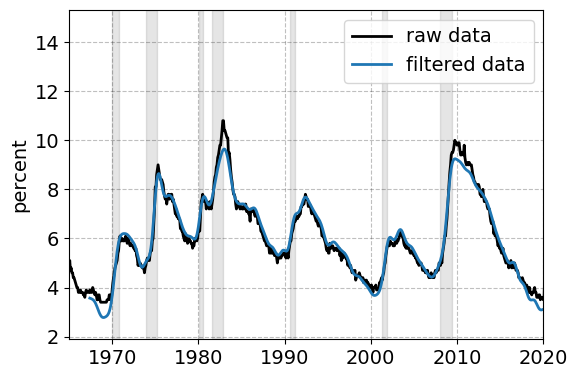

In [5]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# recessions
for start,end in zip(start_vec,end_vec):
    ax.axvspan(start,end,color='black',alpha=0.10)

ax.plot(data['u'],label=f'raw data',color='black',lw=2)
ax.plot(u,label=f'filtered data',color=colors[0],lw=2)

# details
ax.set_xlim([np.datetime64('1965'),np.datetime64('2020')])
ax.set_ylabel('percent')
ax.legend(frameon=True)

# save
fig.tight_layout()
fig.savefig(f'results/unemployment.pdf')

### 4.2. <a id='toc4_2_'></a>[transition rates](#toc0_)

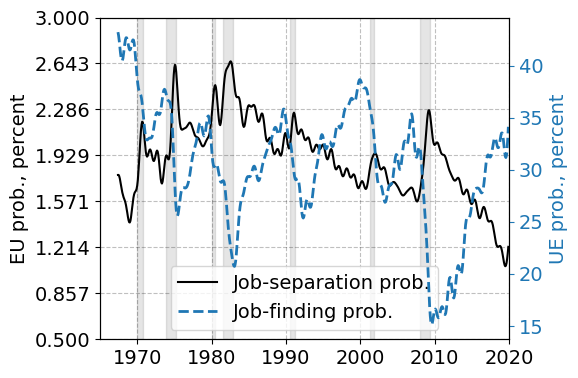

In [6]:
fig = plt.figure(figsize=(6,6/1.5))
ax1 = fig.add_subplot(1,1,1)

# recessions
for start,end in zip(start_vec,end_vec):
    ax1.axvspan(start,end,color='black',alpha=0.10)

ax1.plot(EU,label=f'Job-separation prob.',color='black',lw=1.5)
ax1.plot(np.nan*np.ones(1),label=f'Job-finding prob.',color=colors[0],ls='--',lw=2) # ghost for legend

ax2 = ax1.twinx()
ax2.plot(UE,label=f'Job-finding prob.',color=colors[0],ls='--',lw=2)
ax2.grid(None)

# determine which plot has finer grid -> set pointers accordingly
l1 = len(ax1.get_yticks())
l2 = len(ax2.get_yticks())
if l1 > l2:
  a = ax1
  b = ax2
  l = l1
else:
  a = ax2
  b = ax1
  l = l2

# respace grid of 'b' axis to match 'a' axis
b_ticks = np.linspace(b.get_yticks()[0],b.get_yticks()[-1],l)
b.set_yticks(b_ticks)

# details
ax1.set_xlim([np.datetime64('1965'),np.datetime64('2020')])
ax1.set_ylabel('EU prob., percent')
ax2.set_ylabel('UE prob., percent')
ax2.yaxis.label.set_color(colors[0])
ax2.tick_params(axis='y', colors=colors[0])

ax1.legend(frameon=True,loc='lower center')

# save
fig.tight_layout()
fig.savefig(f'results/time_series_transition_rates.pdf')

### 4.3. <a id='toc4_3_'></a>[Filtering method](#toc0_)

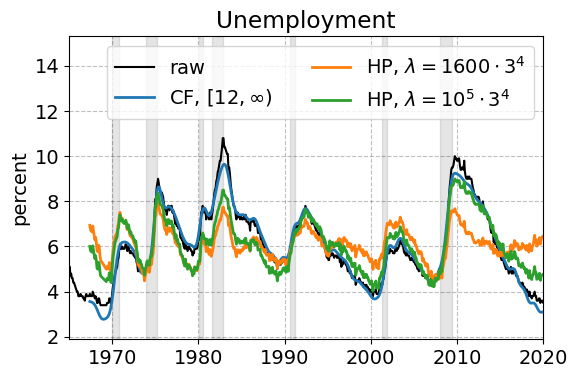

In [7]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# recessions
for start,end in zip(start_vec,end_vec):
    ax.axvspan(start,end,color='black',alpha=0.10)

ax.plot(data['u'],label=f'raw',color='black',lw=1.5)
ax.plot(u,label=f'CF, $[12,\infty)$',lw=2)
ax.plot(u_hp,label=f'HP, $\lambda = 1600 \cdot 3^4$',lw=2)
ax.plot(u_hp_shimer,label=f'HP, $\lambda = 10^5 \cdot 3^4$',lw=2)

# details
ax.set_xlim([np.datetime64('1965'),np.datetime64('2020')])
ax.set_ylabel('percent')
ax.set_title('Unemployment')
ax.legend(frameon=True,ncol=2)

# save
fig.tight_layout()
fig.savefig(f'results/time_series_filtering.pdf')

### 4.4. <a id='toc4_4_'></a>[Approximation](#toc0_)

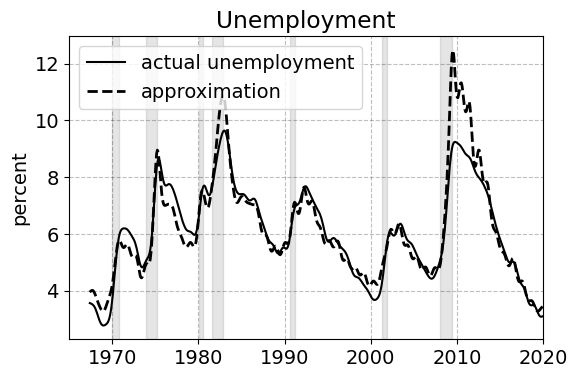

In [8]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# recessions
for start,end in zip(start_vec,end_vec):
    ax.axvspan(start,end,color='black',alpha=0.10)
    
var_u = np.var(u)
ax.plot(u,label=f'actual unemployment',color='black',lw=1.5)

u_approx = 100*EU/(EU+UE)
ax.plot(u_approx,color='black',lw=2,ls='--',label=f'approximation')
    
# details
ax.set_xlim([np.datetime64('1965'),np.datetime64('2020')])
ax.set_ylabel('percent')
ax.set_title('Unemployment')
ax.legend(frameon=True, loc=2)

# save
fig.tight_layout()
fig.savefig(f'results/time_series_approx_error.pdf')

### 4.5. <a id='toc4_5_'></a>[Decomposition](#toc0_)

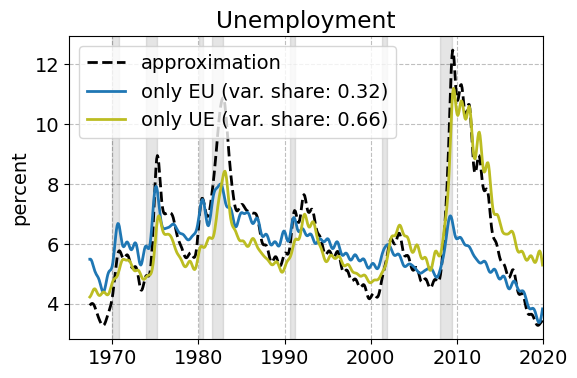

In [9]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# recession
for start,end in zip(start_vec,end_vec):
    ax.axvspan(start,end,color='black',alpha=0.10)
    
# unemployment
ax.plot(u_approx,color='black',lw=2,ls='--',label=f'approximation')

u_EU = 100*EU/(EU+ss_UE)
var_share_u_EU = np.cov(u_approx,u_EU)[0,1]/np.var(u_approx)
ax.plot(u_EU,color=colors[0],lw=2,label=f'only EU (var. share: {var_share_u_EU:.2f})')

u_UE = 100*ss_EU/(ss_EU+UE)
var_share_u_UE = np.cov(u_approx,u_UE)[0,1]/np.var(u_approx)
ax.plot(u_UE,color=colors[-2],lw=2,label=f'only UE (var. share: {var_share_u_UE:.2f})')

# details
ax.set_xlim([np.datetime64('1965'),np.datetime64('2020')])
ax.set_ylabel('percent')
ax.set_title('Unemployment')
ax.legend(frameon=True,loc=2)

# save
fig.tight_layout()
fig.savefig(f'results/time_series_decomposition.pdf')

### 4.6. <a id='toc4_6_'></a>[Dynamic correlation](#toc0_)

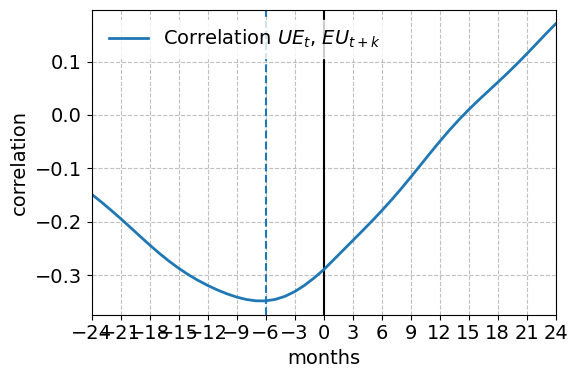

In [10]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

shifts = np.arange(-24,24+1) 
corr = np.array([EU.shift(-shift).to_frame().corrwith(UE).values[0] for shift in shifts])

ax.axvline(shifts[np.argmin(corr)],ls='--',lw=1.5)
ax.axvline(0,color='black',lw=1.5)
ax.plot(shifts,corr,lw=2.0,label='Correlation $UE_t$, $EU_{t+k}$')

# details
ax.set_xlabel(f'months')
ax.set_ylabel('correlation')
ax.set_xticks(shifts[::3])
ax.set_xlim([-24,24])
ax.legend(frameon=True,edgecolor='white')
fig.tight_layout()
fig.savefig(f'results/time_series_lead_lag.pdf')